In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression, make_classification

import sklearn
print(sklearn.__version__)

1.0.2


In [25]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
df = pd.read_csv(r'..\data\processed\combined_metab_lipid_table.csv', index_col=0)
data_cols = df.filter(regex='FBG|RBG').columns
pval_cols = df.filter(regex='pval').columns

In [3]:
animal_phenotypes

,animal,Date of birth,lcms_sampled,glucose_tolerance,10.6g dextrose in 6mL distilled water; total 12.5mL solution,OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),OGTT (AUC),HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
0,1060,2021-01-23,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,1761.75,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
1,1061,2021-01-23,False,NaN,48.0,196.5,344.5,449.5,518.0,284.5,1674.80,NaN,1.7808,1.751032,0.6059,0.595772,2.939099,murky,Slight,NaN
2,1062,2021-01-23,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,1648.75,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
3,1063,2021-01-23,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5485,2.333791,0.8614,0.788828,2.958556,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
4,1074,2021-01-23,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,1350.25,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
5,1075,2021-01-23,False,NaN,169.0,355.0,600.0,600.0,569.5,392.0,3365.00,NaN,1.3107,1.242370,0.5910,0.560190,2.217766,White,Yes,NaN
6,1076,2021-01-23,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,2321.25,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
7,1080,2021-01-24,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9369,1.727832,0.7754,0.691704,2.497937,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
8,1081,2021-01-24,False,NaN,171.0,345.0,547.0,600.0,563.0,428.5,2354.75,NaN,1.3511,1.193551,0.6283,0.555035,2.150406,White,No,NaN
9,1082,2021-01-24,True,diabetic,62.0,258.0,600.0,600.0,571.5,328.5,2224.75,NaN,0.8904,0.818382,0.6515,0.598805,1.366692,White,Yes,NaN


## Perform 3 experiments
1. RF classification (N/I/D) with all features
1. RF classification (N/I/D) with only features that converged under full model
2. RF classification (N/I/D) with only features significant under glucose tolerance and glucose tolerance x sampling

## Hypothesis: RF is robust to non-informative features, so leave-one-out CV will show all 3 models perform approximately the same



In [127]:
# Generate data labels (y) for RF Classifier 

y = fg.set_index('combined_col_name')[['glucose_tolerance']]
y['glucose_tolerance'] = y['glucose_tolerance'].map({'normal': 0, 'impaired': 1, 'diabetic': 2})
y

y_continuous = fg.set_index('combined_col_name')['bg']

### 1) RF classifier with all features

In [22]:
X_all = df[data_cols].T
X_all

Unique ID,unknown_141.01586_16.616,Linoleic Acid_279.23234_1.591,unknown_496.33981_2.597,trans-Petroselinic acid_281.24793_1.568,Uric acid_167.02007_12.732,unknown_520.33987_2.534,unknown_255.23236_1.62,unknown_268.99842_16.592,unknown_524.37116_2.337,unknown_187.00615_2.593,...,unknown_1027.93848_19.865,TG_58:2_960.89709_19.876,unknown_1001.92316_19.882,TG_18:0_18:0_18:0_908.86542_19.885,unknown_948.89648_20.144,unknown_897.82532_20.148,unknown_974.9118_20.163,unknown_593.58716_20.175,unknown_871.80945_20.196,unknown_1003.93829_20.435
1076_10_FBG,29.163795,30.152274,29.735454,29.701370,26.700629,28.721319,29.803012,29.047350,28.892166,27.170732,...,17.215913,18.378388,18.336840,18.447194,16.419472,18.897008,16.810111,17.724121,18.400646,16.655211
1062_8_FBG,30.572489,30.703658,29.569621,30.641931,21.774699,27.427681,30.349551,28.813080,28.671019,26.901321,...,16.652292,17.166214,17.882779,19.507955,17.567143,19.348489,17.364343,19.240306,18.585339,16.313637
1093_9_FBG,29.753802,30.603359,30.043032,30.624242,27.051667,28.906704,30.228474,29.137348,28.609728,26.578356,...,19.686602,21.175953,20.788956,21.407793,21.111930,21.529536,20.099612,21.430516,20.968101,19.339229
1060_8_RBG,30.610134,29.309067,29.827946,28.459047,17.431244,29.295561,29.113441,28.848762,28.995708,22.512901,...,18.212006,20.310682,19.423127,20.589383,18.430226,17.921098,18.430542,17.488155,16.202162,17.985491
1091_10_FBG,30.700893,30.505310,29.420633,30.636897,27.163433,28.470314,30.188475,28.977544,28.105805,26.149719,...,17.032234,17.710758,18.448910,19.899861,18.266873,20.133479,17.986741,19.996615,19.778245,17.357845
1092_9_RBG,30.577914,29.114748,29.483693,28.588431,25.867137,29.644309,29.046819,28.993620,28.339876,22.618105,...,17.645873,18.375462,18.748319,19.968825,18.419951,17.824376,18.099621,17.383197,15.556400,17.582655
1093_10_RBG,30.656929,29.416945,29.886091,28.685024,26.188412,29.792770,29.130352,29.043613,28.603652,22.397004,...,18.320528,18.989137,19.227975,20.089886,18.323302,18.836779,18.145468,18.282680,16.603878,17.887551
1082_10_FBG,30.604336,30.081204,29.609038,30.257619,26.977695,28.204534,29.891213,28.981538,28.704319,27.005622,...,13.960868,16.566651,15.513664,18.843156,15.364329,19.255315,14.496938,19.507853,19.379093,13.846921
1060_9_RBG,30.996475,29.431175,30.018239,28.625995,26.312933,30.211206,29.212933,29.416956,29.331185,22.829664,...,18.340561,19.661018,19.568500,20.581856,18.948519,18.261890,18.854601,17.718258,16.494586,18.466842
1101_9_FBG,30.672859,30.044828,29.620839,29.974868,26.709748,28.574011,29.729036,29.041379,28.488075,26.715388,...,18.237433,19.419490,19.099508,20.166937,19.286479,19.685160,18.324624,19.526233,18.844052,17.739443


In [21]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_all,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.700 (0.100)


### 2) RF classifier with only features that converged under full model

In [51]:
X_only_conv = df.loc[~df[pval_cols].isna().all(axis=1), data_cols].T
X_only_conv

Unique ID,unknown_141.01586_16.616,Linoleic Acid_279.23234_1.591,unknown_496.33981_2.597,trans-Petroselinic acid_281.24793_1.568,Uric acid_167.02007_12.732,unknown_520.33987_2.534,unknown_255.23236_1.62,unknown_268.99842_16.592,unknown_524.37116_2.337,unknown_187.00615_2.593,...,TG_18:2_18:1_24:0_986.91193_19.865,unknown_1027.93848_19.865,TG_58:2_960.89709_19.876,unknown_1001.92316_19.882,TG_18:0_18:0_18:0_908.86542_19.885,unknown_948.89648_20.144,unknown_897.82532_20.148,unknown_974.9118_20.163,unknown_871.80945_20.196,unknown_1003.93829_20.435
1076_10_FBG,29.163795,30.152274,29.735454,29.701370,26.700629,28.721319,29.803012,29.047350,28.892166,27.170732,...,17.330527,17.215913,18.378388,18.336840,18.447194,16.419472,18.897008,16.810111,18.400646,16.655211
1062_8_FBG,30.572489,30.703658,29.569621,30.641931,21.774699,27.427681,30.349551,28.813080,28.671019,26.901321,...,17.634751,16.652292,17.166214,17.882779,19.507955,17.567143,19.348489,17.364343,18.585339,16.313637
1093_9_FBG,29.753802,30.603359,30.043032,30.624242,27.051667,28.906704,30.228474,29.137348,28.609728,26.578356,...,20.504554,19.686602,21.175953,20.788956,21.407793,21.111930,21.529536,20.099612,20.968101,19.339229
1060_8_RBG,30.610134,29.309067,29.827946,28.459047,17.431244,29.295561,29.113441,28.848762,28.995708,22.512901,...,19.499073,18.212006,20.310682,19.423127,20.589383,18.430226,17.921098,18.430542,16.202162,17.985491
1091_10_FBG,30.700893,30.505310,29.420633,30.636897,27.163433,28.470314,30.188475,28.977544,28.105805,26.149719,...,18.058011,17.032234,17.710758,18.448910,19.899861,18.266873,20.133479,17.986741,19.778245,17.357845
1092_9_RBG,30.577914,29.114748,29.483693,28.588431,25.867137,29.644309,29.046819,28.993620,28.339876,22.618105,...,18.825216,17.645873,18.375462,18.748319,19.968825,18.419951,17.824376,18.099621,15.556400,17.582655
1093_10_RBG,30.656929,29.416945,29.886091,28.685024,26.188412,29.792770,29.130352,29.043613,28.603652,22.397004,...,19.339697,18.320528,18.989137,19.227975,20.089886,18.323302,18.836779,18.145468,16.603878,17.887551
1082_10_FBG,30.604336,30.081204,29.609038,30.257619,26.977695,28.204534,29.891213,28.981538,28.704319,27.005622,...,15.799069,13.960868,16.566651,15.513664,18.843156,15.364329,19.255315,14.496938,19.379093,13.846921
1060_9_RBG,30.996475,29.431175,30.018239,28.625995,26.312933,30.211206,29.212933,29.416956,29.331185,22.829664,...,19.624631,18.340561,19.661018,19.568500,20.581856,18.948519,18.261890,18.854601,16.494586,18.466842
1101_9_FBG,30.672859,30.044828,29.620839,29.974868,26.709748,28.574011,29.729036,29.041379,28.488075,26.715388,...,19.243350,18.237433,19.419490,19.099508,20.166937,19.286479,19.685160,18.324624,18.844052,17.739443


In [53]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_only_conv,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.750 (0.144)


### 3) RF classification (N/I/D) with only features significant under glucose tolerance and glucose tolerance interaction with sampling (gluc_tol x feeding)

In [81]:
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = df.loc[(df[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T

In [101]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_only_signf,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.700 (0.135)


In [102]:
n_scores

array([0.66666667, 0.66666667, 0.83333333, 0.5       , 0.83333333,
       0.83333333, 0.5       , 0.5       , 0.66666667, 0.66666667,
       0.83333333, 0.66666667, 0.66666667, 0.66666667, 0.83333333,
       0.66666667, 0.66666667, 1.        , 0.83333333, 0.5       ])

## Another experiment:
2. RF with indicator variable {0, 1} for RBG/FBG in training data X

## Hypothesis: mild increase in accuracy. 

In [114]:
sampling_indicator_var = fg.set_index('combined_col_name')['bg_type'].map({'FBG': 0, 'RBG': 1})

In [122]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_all.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.687 (0.177)


In [123]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_only_conv.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.710 (0.165)


In [125]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_only_signf.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.703 (0.173)


(array([ 9.,  0.,  0., 17.,  0.,  0., 28.,  0.,  0.,  6.]),
 array([0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 , 0.76, 0.82, 0.88, 0.94, 1.  ]),
 <BarContainer object of 10 artists>)

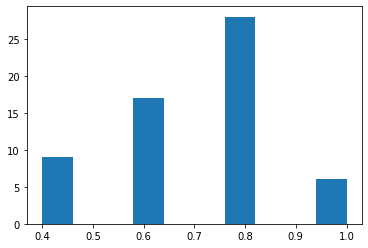

In [126]:
plt.hist(n_scores)

## RF Regressor

In [129]:
rfr = RandomForestRegressor()  # loo = leave-one-out

# evaluate the model
## To do leave-one-out, set n_splits = n_observations in your training data 
cv = RepeatedKFold(n_splits=59, n_repeats=3, random_state=1)
n_scores = cross_val_score(estimator=rfr, 
                           X=X_only_signf, 
                           y=y_continuous, 
                           scoring='neg_mean_absolute_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -24.051 (36.446)


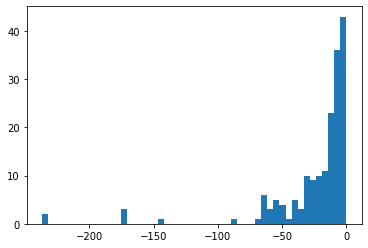

In [133]:
plt.hist(n_scores, bins=50);